**Alumno: Mario Mallea**

# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    279      0 --:--:--  0:00:01 --:--:--   279
100 1546k  100 1546k    0     0   982k      0  0:00:01  0:00:01 --:--:--  982k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    498      0 --:--:-- --:--:-- --:--:--   497
100  385k  100  385k    0     0   382k      0  0:00:01  0:00:01 --:--:--  382k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    726      0 --:--:-- --:--:-- --:--:--   725
100  230k  100  230k    0     0   304k      0 --:--:-- --:--:-- --:--:--  304k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1 MB 25.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4503527 sha256=07f0749b5af8921a6157707d7048364c2062aaa741c6b9733891c3d2e086f975
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [3]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = [] #agrega(crea) en un diccionario los usuarios unicos 
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2]) #items unicos

itemset = np.sort(list(itemset)) #ordena los items

sparse_matrix = np.zeros((len(user_items), len(itemset))) #crea matriz de ceros

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int) #matriz usuarios-items 1 si consumio
    
matrix = sparse.csr_matrix(sparse_matrix.T) #almacenamiento eficiente

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [29]:
def evaluate_model(model, n): #dado un modelo y cantidad de reccomendaciones NDCG@
  #inicializacion en cero
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys(): #para cada usuario en test
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)] #elaborar recomendación
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector) #map
    mean_ndcg += ndcg_at_k(rel_vector, n) #ncdg
  #promedia
  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  return mean_map, mean_ndcg

In [36]:
 user_items_test.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

ejemplo para entender

In [40]:
n=10
model=model_als
mean_map = 0.
mean_ndcg = 0.
u=1
 #para cada usuario en test
rec = [t[0] for t in model.recommend(u, user_item_matrix, n)] #elaborar recomendación
rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
mean_map += mean_average_precision(rel_vector) #map
mean_ndcg += ndcg_at_k(rel_vector, n) #ncdg
print(rec)
print(rel_vector)
user_items_test[u] #ojo 257 esta en rec y rel_vector ... chek

[749, 136, 748, 346, 339, 13, 24, 257, 267, 241]
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0])]


[1,
 2,
 8,
 9,
 21,
 22,
 26,
 30,
 32,
 34,
 37,
 38,
 40,
 63,
 68,
 75,
 89,
 93,
 99,
 105,
 119,
 131,
 133,
 135,
 136,
 138,
 141,
 144,
 146,
 147,
 158,
 166,
 173,
 176,
 179,
 181,
 187,
 194,
 197,
 205,
 211,
 220,
 234,
 237,
 239,
 246,
 247,
 249,
 256,
 257,
 268,
 269,
 270,
 271]

In [19]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [20]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** Consiste en aprender representaciones de usuarios e items de manera alterna en el problema de minimización usual, luego el producto punto de estos vectores deberían reducir el error cuadrático medio con respecto a los ratings reales. Así si el método aprende y generaliza bien se puede usar como aproximador de rating

In [21]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [22]:
show_recommendations(model_als, user=77, n=10)

movieid
273                                          Heat (1995)
256    When the Cats Away (Chacun cherche son chat) (...
258                                       Contact (1997)
754                                    Red Corner (1997)
409                                          Jack (1996)
292                                      Rosewood (1997)
49                                           I.Q. (1994)
299                                       Hoodlum (1997)
327                                      Cop Land (1997)
125                                    Phenomenon (1996)
Name: title, dtype: object

In [27]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.059567276510542826
ndcg: 0.32006125574272587


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [41]:
iteraciones= [5,10,50,100]
resultado=[]
for i in iteraciones: 
    # Definimos y entrenamos el modelo con optimización ALS
  model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=i, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)
  resultado.append((maprec,ndcg))


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

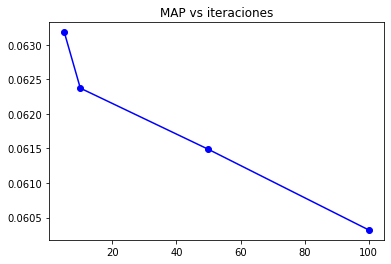

In [44]:
import matplotlib.pyplot as plt
plt.plot(iteraciones,[i[0] for i in resultado], 'bo-')
plt.title("MAP vs iteraciones")
plt.show()

Disminuye el error promedio cuando aumentan las iteraciones de optimización

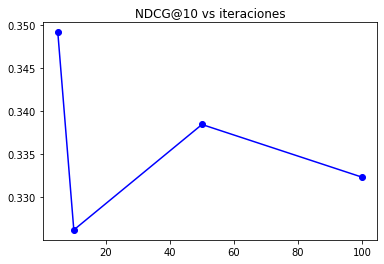

In [45]:
import matplotlib.pyplot as plt
plt.plot(iteraciones,[i[1] for i in resultado], 'bo-')
plt.title("NDCG@10 vs iteraciones")
plt.show()

NDCG empeora

In [48]:
factors= [10,100,1000]
resultado=[]
for f in factors: 
    # Definimos y entrenamos el modelo con optimización ALS
  model_als = implicit.als.AlternatingLeastSquares(factors=f, iterations=10, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)
  resultado.append((maprec,ndcg))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

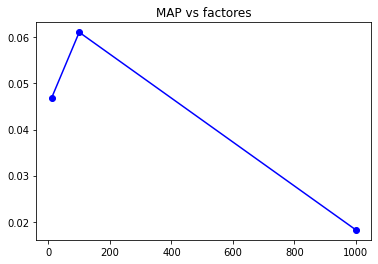

In [50]:
plt.plot(factors,[i[0] for i in resultado], 'bo-')
plt.title("MAP vs factores")
plt.show()

el error se reduce considerando más factores

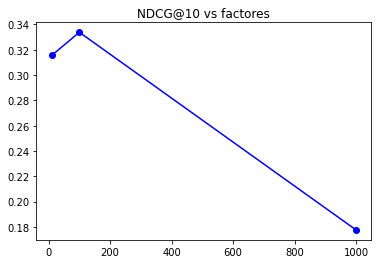

In [51]:
plt.plot(factors,[i[1] for i in resultado], 'bo-')
plt.title("NDCG@10 vs factores")
plt.show()

NDCG mejora y luego empeora

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

BPR busca aprender directamente una función de ranking a través de un enfoque bayesiano y vía SGD

In [52]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

  0%|          | 0/40 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [53]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257                            Men in Black (1997)
299                                 Hoodlum (1997)
285                          Secrets & Lies (1996)
301                                In & Out (1997)
746                             Real Genius (1985)
306    Mrs. Brown (Her Majesty, Mrs. Brown) (1997)
244                  Smilla's Sense of Snow (1997)
267                                        unknown
321                                  Mother (1996)
327                                Cop Land (1997)
Name: title, dtype: object

In [54]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                Delicatessen (1991)
78                   Free Willy (1993)
172    Empire Strikes Back, The (1980)
209          This Is Spinal Tap (1984)
173         Princess Bride, The (1987)
203                  Unforgiven (1992)
68                    Crow, The (1994)
95                      Aladdin (1992)
21       Muppet Treasure Island (1996)
233                 Under Siege (1992)
Name: title, dtype: object

In [55]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05360285094331287
ndcg: 0.33078101071975496


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

In [56]:
iteraciones= [5,10,50,100]
resultado=[]
for i in iteraciones: 
    # Definimos y entrenamos el modelo con optimización ALS
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=i, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)
  resultado.append((maprec,ndcg))


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

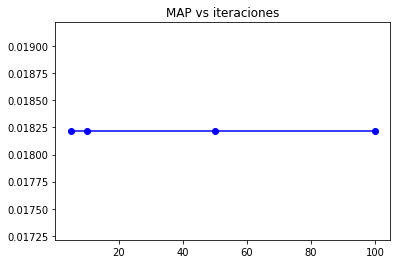

In [57]:
plt.plot(iteraciones,[i[0] for i in resultado], 'bo-')
plt.title("MAP vs iteraciones")
plt.show()

El método converge rápidamente y no varía su error con más entrenamiento

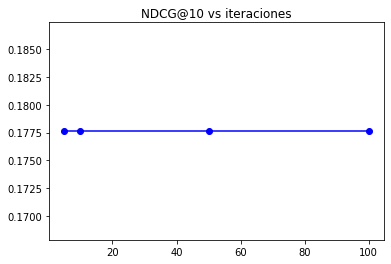

In [58]:
plt.plot(iteraciones,[i[1] for i in resultado], 'bo-')
plt.title("NDCG@10 vs iteraciones")
plt.show()

lo mismo sucede con NDCG

In [59]:
factors= [10,100,1000]
resultado=[]
for f in factors: 
    # Definimos y entrenamos el modelo con optimización ALS
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f, iterations=40, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)
  resultado.append((maprec,ndcg))


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

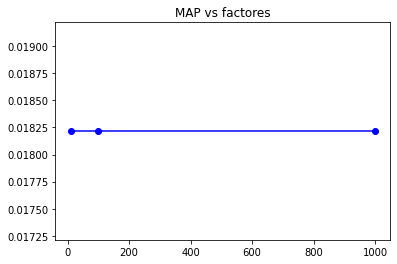

In [60]:
plt.plot(factors,[i[0] for i in resultado], 'bo-')
plt.title("MAP vs factores")
plt.show()

Nuevamente, no se ve afectado el error con las dimensiones consideradas

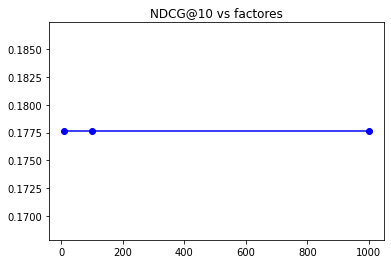

In [61]:
plt.plot(factors,[i[1] for i in resultado], 'bo-')
plt.title("NDCG@10 vs factores")
plt.show()

lo mismo sucede con NDCG